In [1]:
from vpython import * 
from pypylon import pylon
import cv2 as cv
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
from matplotlib.ticker import FormatStrFormatter
import time
from openpyxl import Workbook
import xlwt
from datetime import datetime
import random
from itertools import count
from IPython.display import display, clear_output
from matplotlib.animation import FuncAnimation
from drawnow import drawnow
from bokeh.plotting import curdoc, figure
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd
import numpy as np
import numpy.ma as ma
import math
import time
import circle_fit as cf
import matplotlib.colors as mcolors
import config_constants as cc
%matplotlib inline 

<IPython.core.display.Javascript object>

In [2]:
conversion = cc.conversion
xcoords = []
ycoords = []

# conecting to the first available camera
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()
#camera.Width = 4112
#camera.Height = 2172
camera.CenterX.SetValue(True)
camera.Width.SetValue(2956)
camera.CenterY.SetValue(True)
camera.Height.SetValue(1988)
camera.Close()
# Grabing Continusely (video) with minimal delay
camera.StartGrabbing(pylon.GrabStrategy_LatestImageOnly)
converter = pylon.ImageFormatConverter()

# converting to opencv bgr format
converter.OutputPixelFormat = pylon.PixelType_BGR8packed
converter.OutputBitAlignment = pylon.OutputBitAlignment_MsbAligned


#def for background change to black and white
object_detector = cv.createBackgroundSubtractorMOG2(history=100, varThreshold=70)

#def for counter 
t = 0
tmax = 1000
dt = 1
#display 
scene1 = canvas()
#display(fig)
#measure the time
st = time.time()
#Camera grabbing while loop and set count time 
while camera.IsGrabbing() and t < tmax:
    grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
    if grabResult.GrabSucceeded():
        # Access the image data
        image = converter.Convert(grabResult)
        img = image.GetArray()
    if not grabResult.GrabSucceeded: break
    
#Frame color control 
    GrayFrame = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #blurFrame = cv.GaussianBlur(GrayFrame, (17,17),0)
    # Set up the detector with default parameters.
    
    # Threshold image to binary
    thresh = cv.threshold(GrayFrame, 254, 255, cv.THRESH_BINARY)[1]
    thresh2 = cv.resize(thresh, (1478, 994))
    cv.imshow("Thresh", thresh2)

    # Find contours
    contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Iterate through contours and find largest contour
    largest_contour_area = 0
    largest_contour = None
    for contour in contours:
        area = cv.contourArea(contour)
        if area > largest_contour_area:
            largest_contour_area = area
            largest_contour = contour

    # Draw outline of largest contour on input image
    img_with_contour = cv.cvtColor(thresh, cv.COLOR_GRAY2BGR)
    cv.drawContours(img_with_contour, [largest_contour], 0, (0, 255, 0), 1)

    # Get coordinates of center of largest contour
    M = cv.moments(largest_contour)
    cx = (M['m10'] / M['m00'])
    cy = (M['m01'] / M['m00'])
    subpixel_contour = cv.cornerSubPix(GrayFrame, np.float32([(cx,cy)]), winSize=(1,1), zeroZone=(-1,-1), criteria=(cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.00001))
    subpixel_point = subpixel_contour[0]
    cv.circle(img_with_contour, (int(subpixel_point[0]), int(subpixel_point[1])), 2, (255,0,0), 1)
    pcx = subpixel_point[0]
    pcy = subpixel_point[1]

    # Draw a circle at the center of the largest contour
    #cv.circle(img_with_contour, (cx, cy), 5, (255, 0, 0), 1)

    # Show the input image with contour and center
    imS = cv.resize(img_with_contour, (1478, 994)) # Resize image
    cv.imshow("Image with contour", imS)

    # Print coordinates of center of largest contour
    #print(f"({cx}, {cy})")
    xcoords.append(pcx*conversion)
    ycoords.append(pcy*conversion)

    key = cv.waitKey(30) 
    if key == 27 : break
    #count time 
    t = t + dt
    
#camera control         
camera.StopGrabbing()
cv.destroyAllWindows()

<IPython.core.display.Javascript object>

In [3]:
print(xcoords)
print(ycoords)

[14.206280136108399, 14.206335067749023, 14.20634651184082, 14.206024932861327, 14.20609130859375, 14.206576538085937, 14.206422042846679, 14.206137084960938, 14.205921936035155, 14.206147384643554, 14.2064884185791, 14.206269836425781, 14.206140518188477, 14.20645751953125, 14.205814361572266, 14.206402587890624, 14.206037521362305, 14.206134796142578, 14.205988311767578, 14.206607437133789, 14.20586471557617, 14.206266403198242, 14.206542205810546, 14.20619659423828, 14.206511306762694, 14.206575393676758, 14.206475830078125, 14.206174850463867, 14.206684112548828, 14.20649070739746, 14.206692123413086, 14.20605354309082, 14.206541061401367, 14.206587982177734, 14.206747055053711, 14.20634536743164, 14.20608787536621, 14.206250381469726, 14.206630325317382, 14.206681823730468, 14.206709289550782, 14.206757354736327, 14.206877517700194, 14.206615447998047, 14.207386779785155, 14.206766510009766, 14.20653076171875, 14.206858062744141, 14.206292724609375, 14.206700134277343, 14.20625381

In [4]:
print(cx)
print(cy)

1515.3142250530786
1336.2820240622787


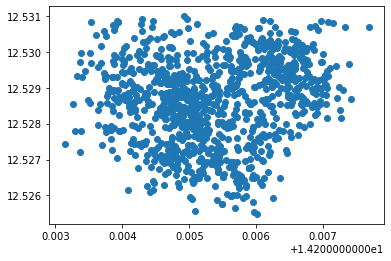

In [5]:
plt.scatter(xcoords,ycoords)

Center coordinates: 14.205613304514547 12.52851838190256 mm
Radius: 0.0014013821799360292 mm
Residual error: 0.00035738836374515437 mm


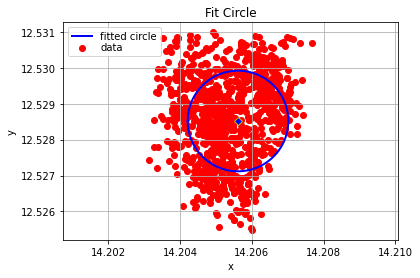

In [6]:
data = [[xcoords[i], ycoords[i]] for i in range(len(xcoords))]
xc, yc, r, sigma = cf.least_squares_circle((data))
print('Center coordinates:',xc,yc,'mm')
print('Radius:',r,'mm')
print('Residual error:',sigma,'mm')

cf.plot_data_circle(xcoords,ycoords,xc,yc,r)

In [7]:
et = time.time()
elapsed_time = et - st
print ('CPU execution time code', time.process_time(), 'seconds')
print('Execution time:', elapsed_time, 'seconds')

CPU execution time code 154.921875 seconds
Execution time: 69.31840372085571 seconds


In [8]:
x_steps = np.count_nonzero(xcoords)
y_steps = np.count_nonzero(ycoords)
print(x_steps, y_steps)

1000 1000


In [9]:
steps = list(range(1,x_steps+1))
print(steps)   

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

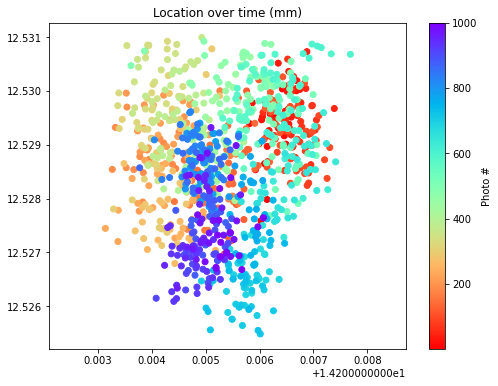

In [10]:
figure = plt.figure(figsize=(8, 6))
plt.scatter(xcoords,ycoords,c=steps,cmap='rainbow_r')
plt.colorbar(label='Photo #')
plt.title("Location over time (mm)")
plt.axis('equal')
plt.show()

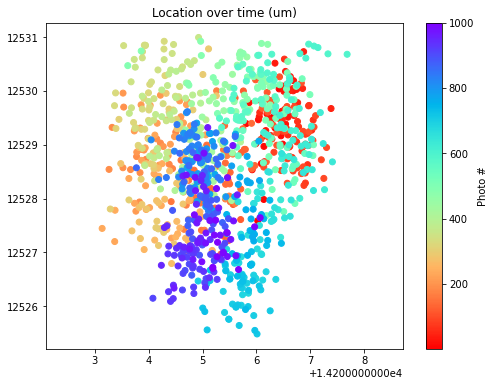

In [11]:
xcoords_um = [x * 1000 for x in xcoords]
ycoords_um = [y * 1000 for y in ycoords]

figure = plt.figure(figsize=(8, 6))
plt.scatter(xcoords_um,ycoords_um,c=steps,cmap='rainbow_r')
plt.colorbar(label='Photo #')
plt.title("Location over time (um)")
plt.axis('equal')
plt.show()

In [12]:
print("Standard deviation in x (um):",np.std(xcoords_um))

Standard deviation in x (um): 0.9108732874239277


In [13]:
print("Standard deviation in y (um):",np.std(ycoords_um))

Standard deviation in y (um): 1.1927771425585347


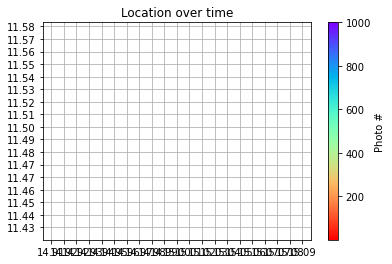

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

#ticks
major_ticks = np.arange(0, 25, 0.009375)
minor_ticks = np.arange(0, 25, 0.009375)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

#corresponding grid
ax.grid(which='both')

plt.scatter(xcoords,ycoords,c=steps,cmap='rainbow_r')
plt.colorbar(label='Photo #')
plt.title("Location over time")
plt.axis('equal')
plt.xlim(14.9,15.1)
plt.ylim(11.4,11.6)
plt.show()